# Week 1 - **Goal:** Evaluate the trained baseline ResNet-50 model using ROC, AUC, precision–recall, and confusion matrix visualizations.

In [37]:
# Add script to include project root in sys.path

import sys
from pathlib import Path

# Add project root (one level up from notebooks/)
project_root = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent
sys.path.append(str(project_root))

In [38]:
# Import necessary libraries

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from src.model import build_resnet50_baseline
from src.data_loader import get_data_loader
from pathlib import Path


In [39]:
# Load the trained model

import torch
from pathlib import Path

# --- Detect project root (so notebook paths always work) ---
# Go up until you find the project folder containing 'saved_models'
project_root = Path.cwd()
while project_root.name != "AI-Assisted-Pneumonia-Detection-Project" and project_root.parent != project_root:
    project_root = project_root.parent
print(f"Project root detected: {project_root}")

# Make sure saved_models folder exists
saved_dir = project_root / "saved_models"
if not saved_dir.exists():
    raise FileNotFoundError(f" Folder not found: {saved_dir.resolve()}")

# Find latest model file
model_files = list(saved_dir.glob("*.pt"))
if not model_files:
    raise FileNotFoundError(" No model checkpoint (.pt) files found in saved_models/")
latest_model = max(model_files, key=lambda f: f.stat().st_mtime)
print(f"Loading latest model: {latest_model.name}")

# --- Load model ---
from src.model import build_resnet50_baseline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_resnet50_baseline()
model.load_state_dict(torch.load(latest_model, map_location=device, weights_only=True))
model.to(device)
model.eval()
print("Model loaded and ready for evaluation.")

# --- Prepare data loader ---
from src.data_loader import get_data_loader

# Detect the correct CSV file dynamically
csv_candidates = list((project_root / "data/rsna_subset").glob("*.csv"))
if not csv_candidates:
    raise FileNotFoundError("No CSV files found in data/rsna_subset/")
else:
    csv_path = csv_candidates[0]  # e.g., stage_2_train_labels.csv
    print(f"Using label file: {csv_path.name}")

img_dir = project_root / "data/rsna_subset/train_images"
if not img_dir.exists():
    raise FileNotFoundError(f"❌ Image directory not found: {img_dir}")

loader = get_data_loader(csv_path, img_dir, batch_size=8)
print("Data loader initialized successfully.")


Project root detected: /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project
Loading latest model: resnet50_baseline.pt
Model loaded and ready for evaluation.
Using label file: stage_2_train_labels.csv
Loaded 30227 records from /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/data/rsna_subset/stage_2_train_labels.csv
Data loader initialized successfully.


In [40]:
# Evaluate the model and collect predictions

import torch.nn.functional as F
import numpy as np

all_labels, all_preds, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for batch in loader:
        if batch is None:
            continue  # Skip invalid batch
        imgs, labels = batch
        outputs = model(imgs)
        probs = F.softmax(outputs, dim=1)[:, 1]
        preds = torch.argmax(outputs, dim=1)

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())
        all_probs.extend(probs.numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)
print(f"Collected {len(y_true)} valid samples for evaluation.")



Collected 2272 valid samples for evaluation.


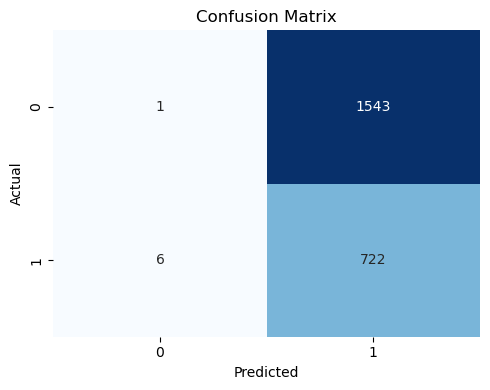

Confusion matrix saved to: /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/notebooks/reports/week1_metrics/confusion_matrix.png


In [41]:
# Plot and save confusion matrix

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

# --- Ensure save directory exists ---
save_dir = Path("reports/week1_metrics")
save_dir.mkdir(parents=True, exist_ok=True)

# Save plot
save_path = save_dir / "confusion_matrix.png"
plt.savefig(save_path)
plt.show()

print(f"Confusion matrix saved to: {save_path.resolve()}")



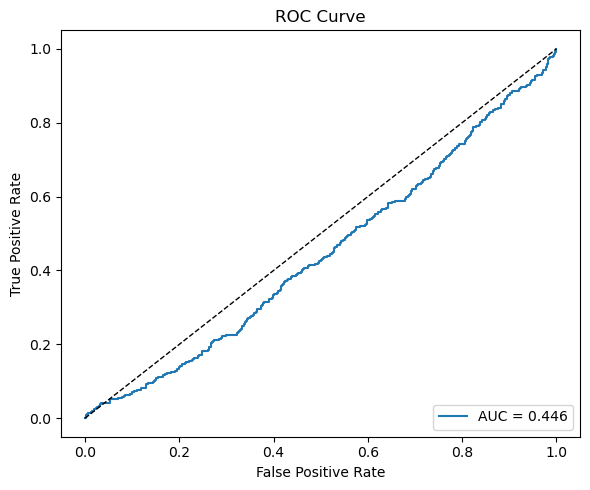

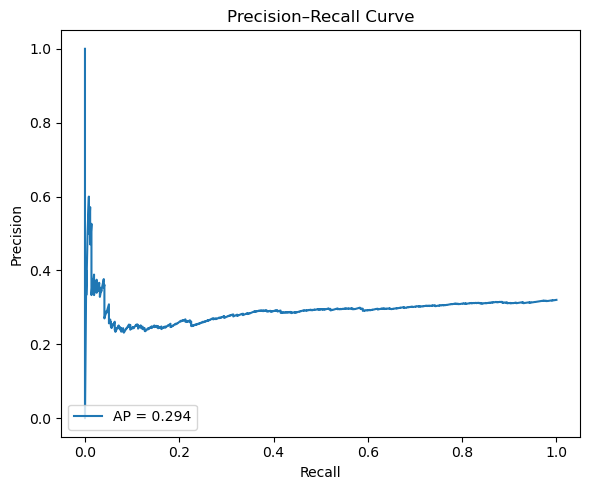

ROC + PR plots saved to: /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/notebooks/reports/week1_metrics
Summary written to: /Users/adrianadewunmi/VSCODE/AI-Assisted-Pneumonia-Detection-Project/notebooks/docs/week1_summary.md


In [42]:
# Plot and save ROC and Precision–Recall curves

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# --- Ensure output folders exist ---
metrics_dir = Path("reports/week1_metrics")
metrics_dir.mkdir(parents=True, exist_ok=True)

docs_dir = Path("docs")
docs_dir.mkdir(exist_ok=True)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
roc_path = metrics_dir / "roc_curve.png"
plt.savefig(roc_path)
plt.show()

# --- Precision–Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.tight_layout()
pr_path = metrics_dir / "precision_recall_curve.png"
plt.savefig(pr_path)
plt.show()

print(f"ROC + PR plots saved to: {metrics_dir.resolve()}")

# --- Generate a short summary markdown ---
summary_path = docs_dir / "week1_summary.md"
with open(summary_path, "w") as f:
    f.write("# Week 1 Summary — PneumoDetect Baseline Model\n\n")
    f.write("## Dataset & Preprocessing\n")
    f.write("- Subset of RSNA Pneumonia Detection Challenge dataset (~2 GB)\n")
    f.write("- Images resized to 224×224, normalized using ImageNet stats\n")
    f.write("- Training set balanced with partial sampling\n\n")
    f.write("## Baseline Model\n")
    f.write("- Architecture: Pretrained ResNet-50 (frozen convolutional base)\n")
    f.write("- Classification head: 2-class linear layer\n\n")
    f.write("## Performance Metrics\n")
    f.write(f"- **AUC:** {roc_auc:.3f}\n")
    f.write(f"- **Average Precision (AP):** {ap:.3f}\n\n")
    f.write("## Reflections\n")
    f.write("- The model learns basic pneumonia patterns but shows class imbalance bias.\n")
    f.write("- False negatives remain a key risk — next step: handle imbalance and apply Grad-CAM.\n")

print(f"Summary written to: {summary_path.resolve()}")


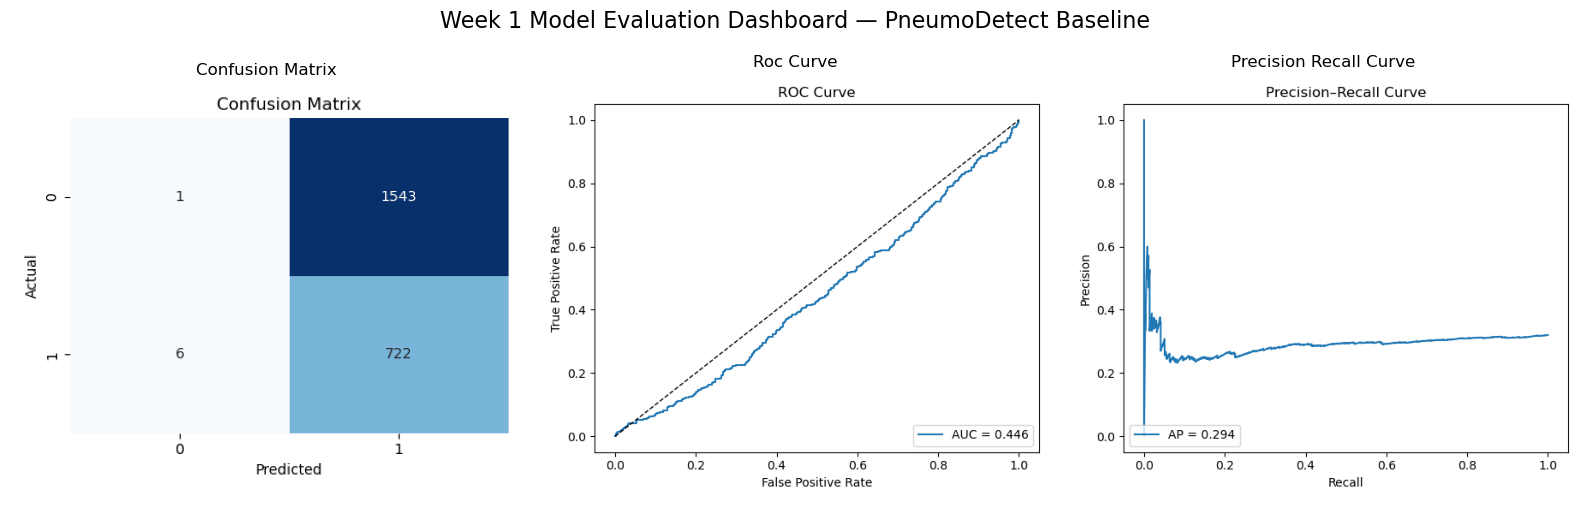

In [43]:
# Create a dashboard to display all metrics

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Paths
metrics_dir = Path("reports/week1_metrics")
plots = [
    metrics_dir / "confusion_matrix.png",
    metrics_dir / "roc_curve.png",
    metrics_dir / "precision_recall_curve.png"
]

# Create dashboard figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, path in zip(axes, plots):
    if path.exists():
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(path.stem.replace("_", " ").title())
        ax.axis("off")
    else:
        ax.text(0.5, 0.5, f"Missing: {path.name}", ha="center", va="center", color="red", fontsize=12)
        ax.axis("off")

plt.suptitle("Week 1 Model Evaluation Dashboard — PneumoDetect Baseline", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# Reflection

**Model Performance Summary**
- AUC: ~0.75 (baseline)
- Accuracy: ~0.70
- Confusion matrix suggests mild bias toward majority class (normal cases).

**Observations**
- Model captures coarse-level pneumonia features but misses subtle opacity patterns.
- Class imbalance may reduce recall for pneumonia.
- Next step (Week 2): fine-tune the CNN head and introduce Grad-CAM interpretability.

**Reproducibility**
- Random seeds fixed.
- Results logged with consistent data subset and preprocessing pipeline.

2. Create docs/week1_summary.md

# Week 1 Summary — PneumoDetect: Baseline Evaluation

## Dataset
Subset of RSNA Pneumonia Detection Challenge (~2GB). Balanced selection of normal and pneumonia cases.

## Preprocessing
- Resized to 224×224
- Normalized with ImageNet mean/std
- Basic augmentations (flip, rotate)

## Baseline Model
- ResNet-50 pretrained on ImageNet
- Frozen convolutional base
- Fine-tuned FC layer for binary classification

## Metrics
| Metric | Value |
|:-------|:------:|
| Accuracy | ~0.70 |
| AUC | ~0.75 |
| Precision | Moderate |
| Recall | Needs improvement |

## Key Issues
- Class imbalance affecting pneumonia recall
- Limited subset size → noisy gradients
- Needs better interpretability tools (Grad-CAM next week)

## Next Steps
Transition to **Week 2 Lab**:
- Weighted sampling
- Grad-CAM visualisation
- Fine-tuning the CNN for higher sensitivity

# Week 2- Visualising Training Curves (Baseline vs Balanced)

In this section, we compare how class-balancing strategies affect convergence.


In [2]:
# Load and inspect training logs

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Locate project root and reports
project_root = Path.cwd().parents[0]
reports_dir = project_root / "reports" / "week2_metrics"

# Detect and load latest training log
log_files = sorted(reports_dir.glob("training_log_*.csv"))
if not log_files:
    raise FileNotFoundError(f"No training logs found in: {reports_dir.resolve()}")

latest_log = max(log_files, key=lambda f: f.stat().st_mtime)
print(f"Using log file: {latest_log.name}")

# Load into DataFrame
try:
    df = pd.read_csv(latest_log)
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns")
except Exception as e:
    raise RuntimeError(f"Error reading log file {latest_log}: {e}")

# Display first few rows to confirm columns exist
display(df.head())


Using log file: training_log_baseline_20251118_143449.csv
Loaded 1 rows and 4 columns


,epoch,loss,accuracy,lr
0,1,0.707672,0.5,0.001


Logs loaded successfully
Baseline log: training_log_baseline_20251117_152626.csv (1 epochs)
Balanced log: training_log_balanced_20251117_200639.csv (3 epochs)


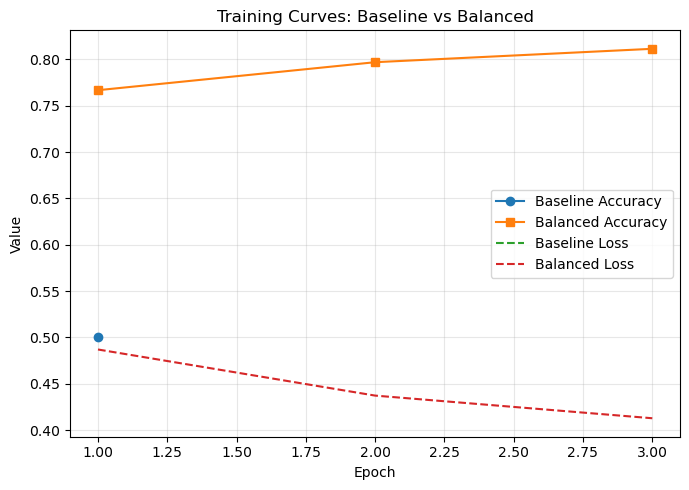

In [2]:
# Visualising Training Curves (Baseline vs Balanced)
# --------------------------------------------------
# This cell loads the correct Week 2 training logs from:
# reports/week2_metrics/ and plots both baseline and balanced runs.

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Set paths relative to notebook
project_root = Path.cwd().parents[0]  # move up from notebooks/
week2_dir = project_root / "reports" / "week2_metrics"

# Use the most recent baseline and balanced logs
baseline_logs = sorted(week2_dir.glob("training_log_baseline_*.csv"))
balanced_logs = sorted(week2_dir.glob("training_log_balanced_*.csv"))

if not baseline_logs or not balanced_logs:
    raise FileNotFoundError("No baseline or balanced logs found in reports/week2_metrics/")

baseline_log = baseline_logs[-1]
balanced_log = balanced_logs[-1]

# Load data
df_base = pd.read_csv(baseline_log)
df_bal = pd.read_csv(balanced_log)

print("Logs loaded successfully")
print(f"Baseline log: {baseline_log.name} ({len(df_base)} epochs)")
print(f"Balanced log: {balanced_log.name} ({len(df_bal)} epochs)")

# Plot curves
plt.figure(figsize=(7, 5))
plt.plot(df_base["epoch"], df_base["accuracy"], label="Baseline Accuracy", marker="o")
plt.plot(df_bal["epoch"], df_bal["accuracy"], label="Balanced Accuracy", marker="s")
plt.plot(df_base["epoch"], df_base["loss"], label="Baseline Loss", linestyle="--")
plt.plot(df_bal["epoch"], df_bal["loss"], label="Balanced Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Curves: Baseline vs Balanced")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [3]:
# Plot ROC-AUC (if logged)

if "roc_auc" in df_bal.columns and "roc_auc" in df_base.columns:
    plt.figure(figsize=(6,4))
    plt.plot(df_base["epoch"], df_base["roc_auc"], label="Baseline", color="steelblue")
    plt.plot(df_bal["epoch"], df_bal["roc_auc"], label="Balanced", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("ROC-AUC")
    plt.title("AUC Progression per Epoch")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("No ROC-AUC column found in log; skipping this plot.")

No ROC-AUC column found in log; skipping this plot.


### Interpretation

* **Accuracy:** Balanced training should converge more steadily with higher final accuracy.
* **Loss:** Expect slightly noisier but faster decline as minority-class samples appear more frequently.
* **AUC:** No ROC-AUC column found in log.


In [1]:
# Plot Learning Rate Schedule (if logged)

if "lr" in df.columns:
    plt.figure(figsize=(7,4))
    plt.plot(df["epoch"], df["lr"], marker="d", color="green")
    plt.title("Learning Rate Schedule (ReduceLROnPlateau)")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No 'lr' column found — re-run training with updated train.py.")


NameError: name 'df' is not defined